In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
test_data = unpickle('C:/Users/Nihal/Downloads/cifar_test_nolabels.pkl/cifar_test_nolabels.pkl')

In [4]:
test_data = test_data[b'data']
test_data = test_data.reshape(-1, 3, 32, 32)
test_data = test_data/255

In [5]:
max_value = np.max(test_data)

# Get the minimum value across the entire array
min_value = np.min(test_data)

print("Maximum value:", max_value)
print("Minimum value:", min_value)

Maximum value: 1.0
Minimum value: 0.0


In [6]:
import numpy as np

# 1. Compute the mean and standard deviation for each channel over all images
mean_per_channel = np.array([0.4914, 0.4822, 0.4465])   # Compute mean along axis 0 (images), 2 (height), and 3 (width)
std_per_channel = np.array([0.2023, 0.1994, 0.2010])    # Compute standard deviation along the same axes

# 2. Normalize the entire test_data tensor using the computed mean and standard deviation
normalized_test_data = (test_data - mean_per_channel.reshape(1, 3, 1, 1)) / std_per_channel.reshape(1, 3, 1, 1)

# Verify the shape of the normalized tensor
print("Shape of the normalized test_data:", normalized_test_data.shape)


Shape of the normalized test_data: (10000, 3, 32, 32)


In [7]:
normalized_test_data_tensor = torch.tensor(normalized_test_data, dtype=torch.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


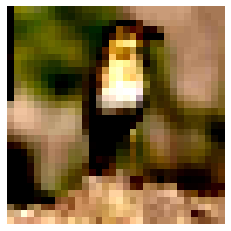

In [8]:
image_tensor = normalized_test_data_tensor[1558]  # Selecting the first image, change index as needed

# Convert the image tensor to a NumPy array and transpose it to (height, width, channels) format
image_np = image_tensor.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [9]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [3,3,3])


print("PreActResNet")

PreActResNet


In [10]:
import torch.backends.cudnn as cudnn

net = PreActResNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [11]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       PreActBlock-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      PreActBlock-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

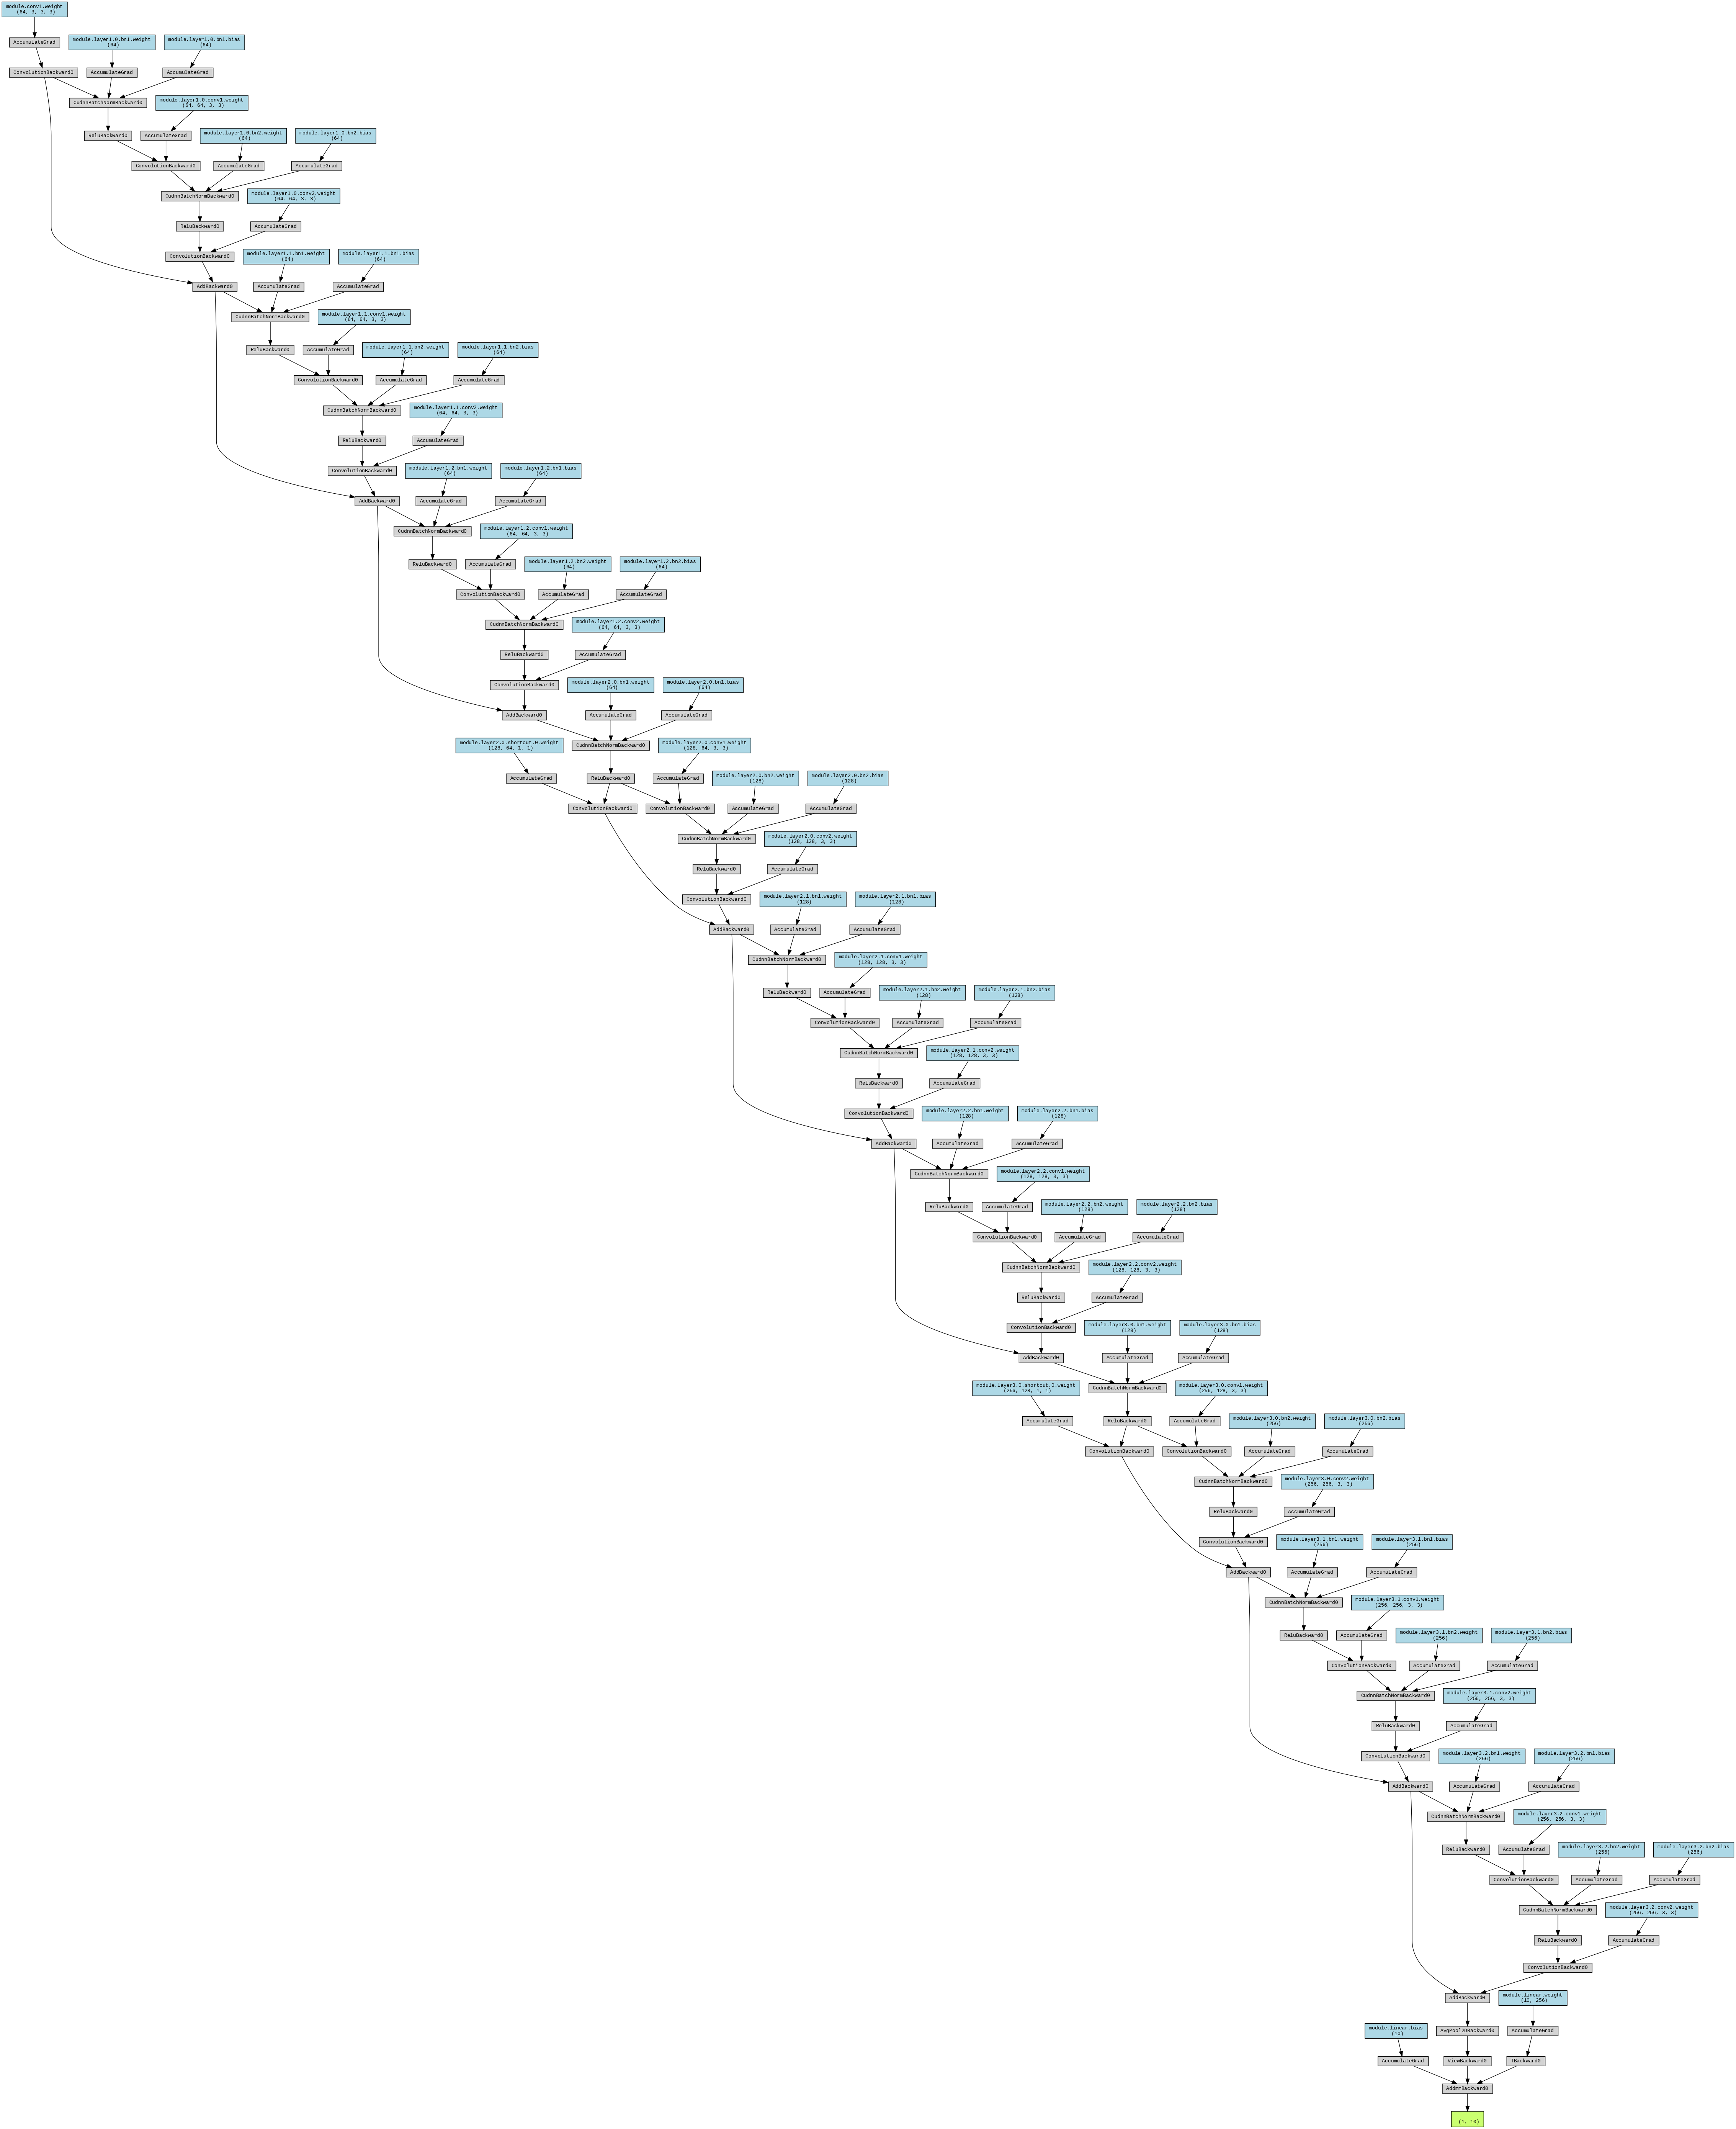

In [77]:
checkpoint = torch.load('C:/Users/Nihal/Documents/pytorch-cifar-master/prereswithoutaug/checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']


In [78]:
best_acc


93.38

In [79]:
def test(net, test_data, batch_size=100):
    net.eval()
    predicted_labels = []
    with torch.no_grad():
        num_samples = len(test_data)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_data = test_data[start_idx:end_idx]
            outputs = net(batch_data)
            _, predicted = outputs.max(1)
            predicted_labels.extend(predicted.tolist())  # Extend the list with predictions from the current batch
    return predicted_labels

In [80]:
predicted_labels = test(net,normalized_test_data_tensor)

In [82]:
import pandas as pd



# Create a DataFrame with ID as index values and Labels column
df = pd.DataFrame({'Labels': predicted_labels}, index=[i for i in range(len(predicted_labels))])

# Write the DataFrame to a CSV file with index column name as 'ID'
df.to_csv('predicted_labels_preactresnet_final.csv', index_label='ID')